In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from lib.model import FNO1d
from lib.utils import relative_l2_error
from lib.dataset import PDEDatasetAll2All

In [12]:
torch.manual_seed(0)
np.random.seed(0)

In [13]:
DEVICE = "cpu"

In [14]:
modes = 16
width = 64
fno = FNO1d(modes, width).to(DEVICE)  # model
fno.load_state_dict(torch.load("models/tfno_model.pth", weights_only=True))

<All keys matched successfully>

In [15]:
time_pairs = [(0, 4)]
dataset = (
    PDEDatasetAll2All(
        "data/test_allen_cahn_fourier.npy", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_gmm.npy", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_piecewise.npy", device=DEVICE, time_pairs=time_pairs
    )
)

In [16]:
BATCH_SIZE = 5

In [17]:
sampler = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

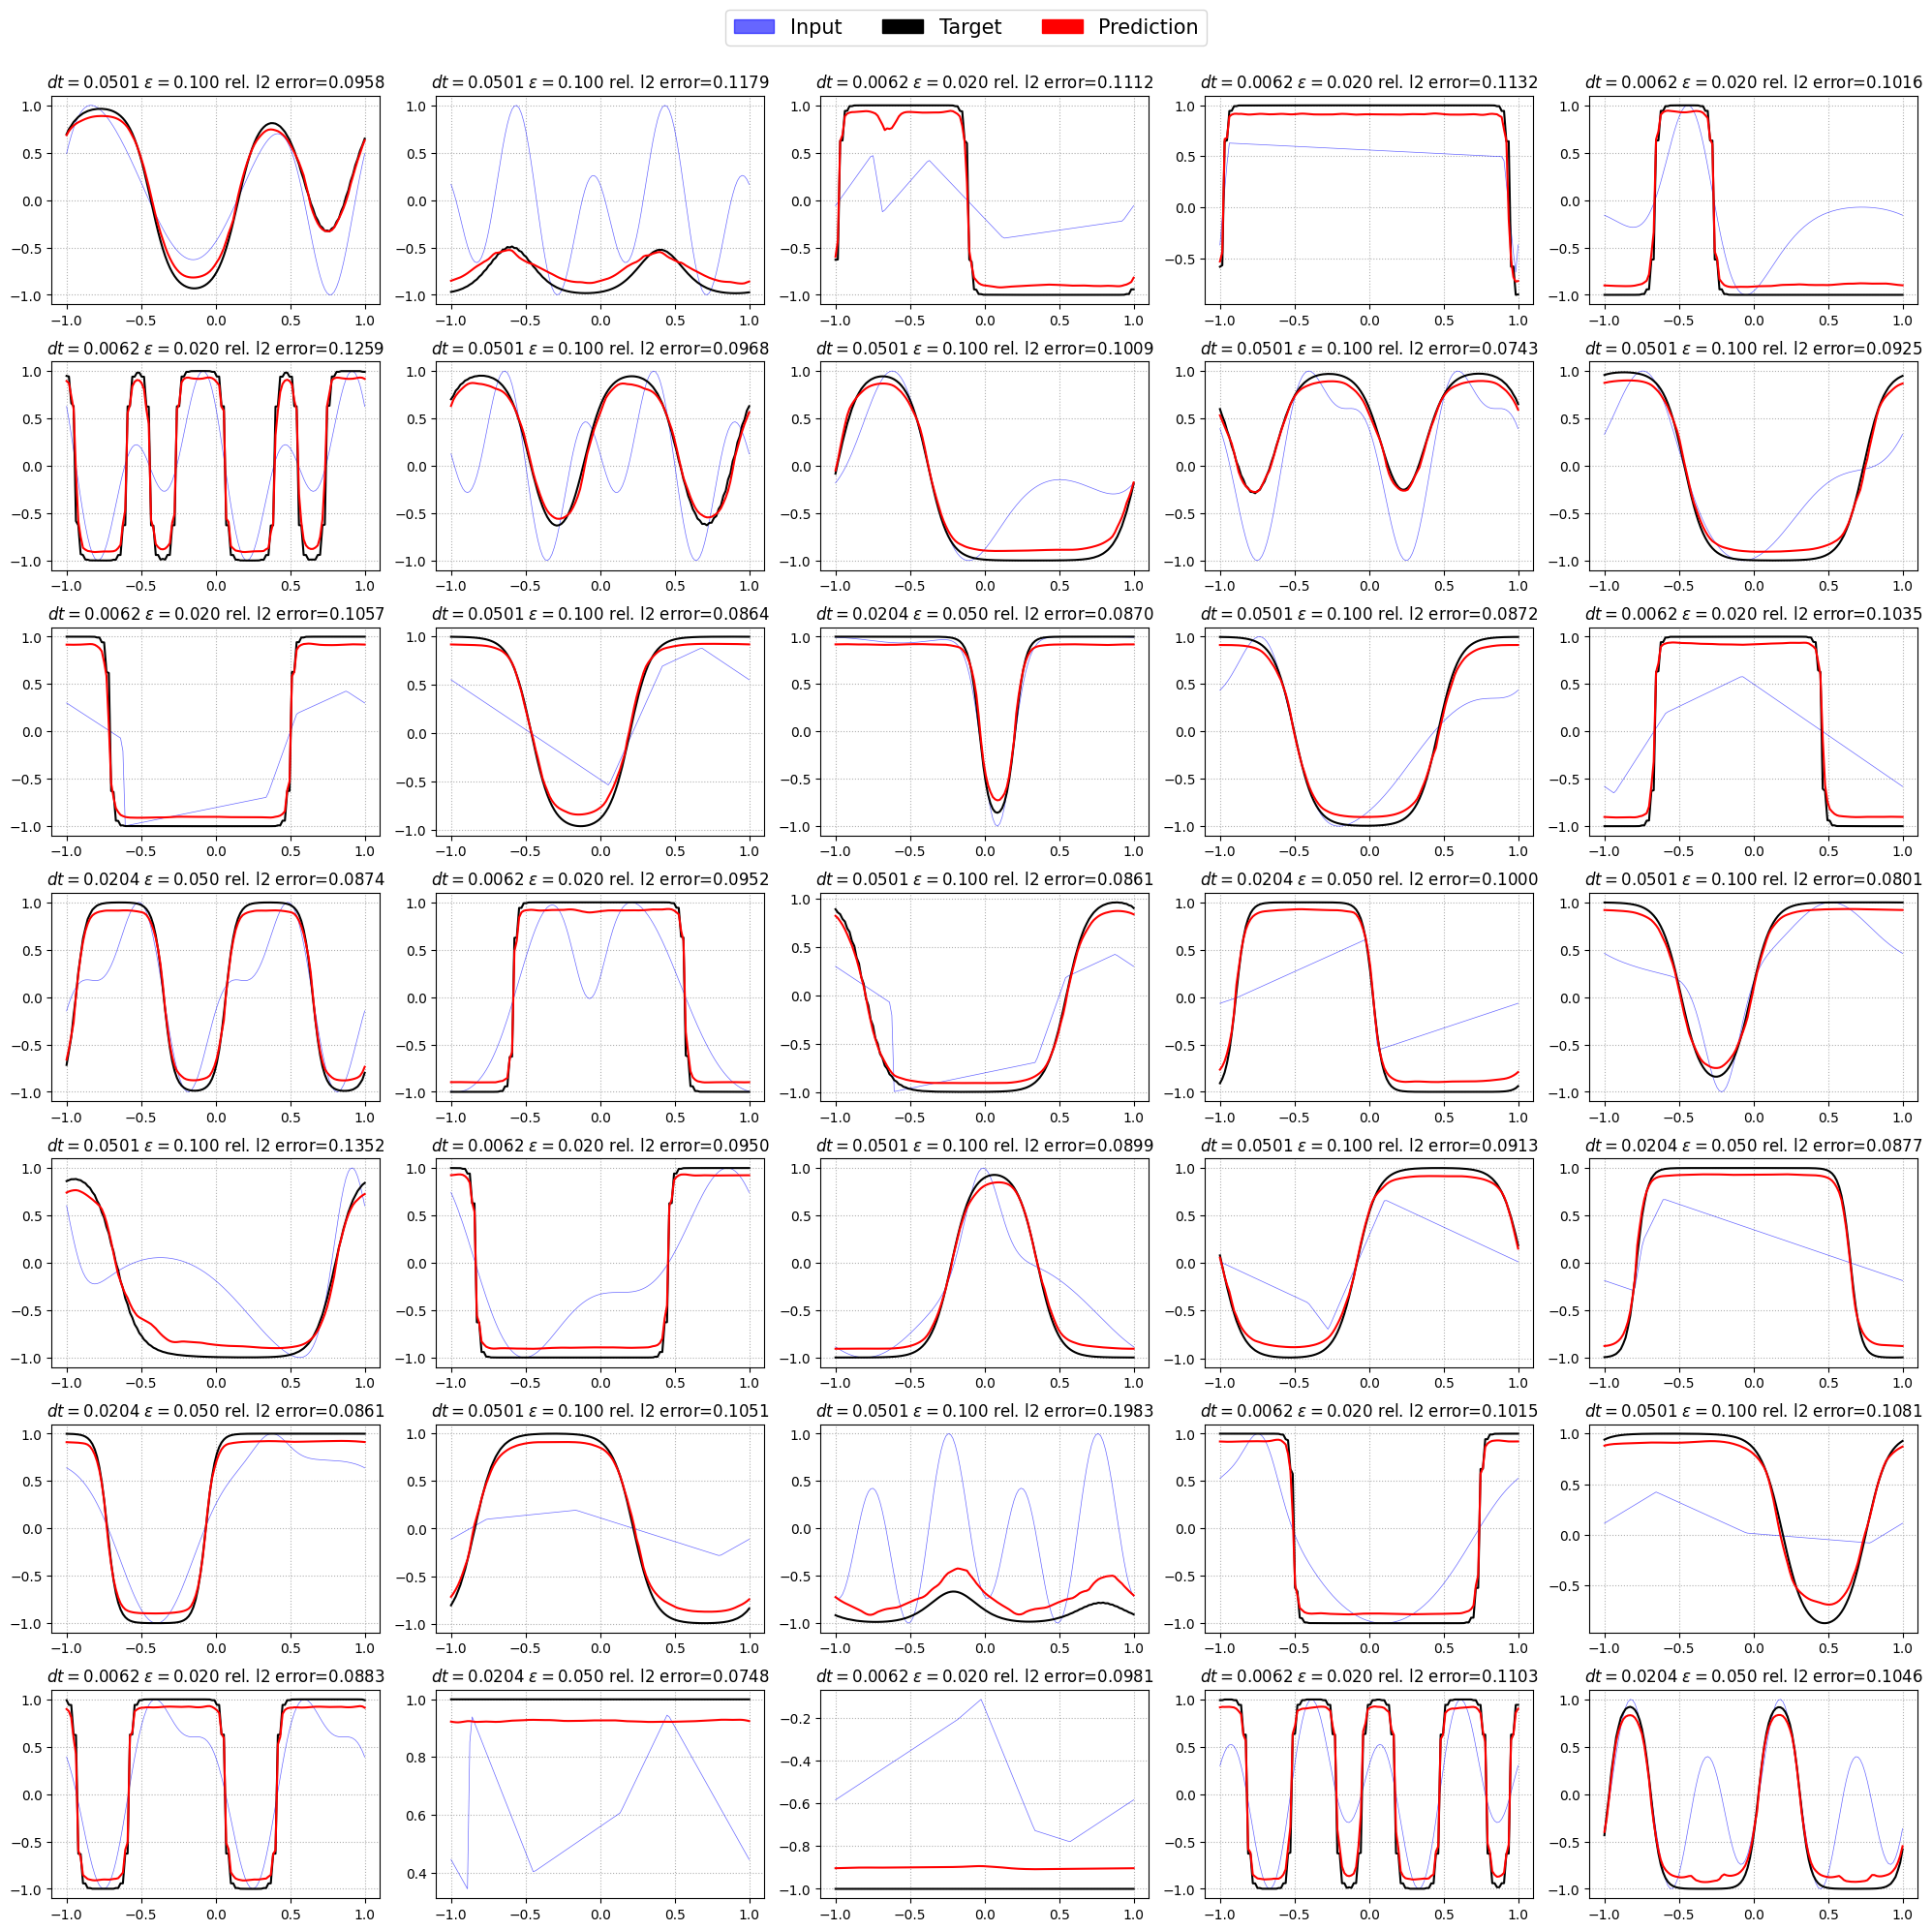

In [18]:
fig, axs = plt.subplots(7, BATCH_SIZE, figsize=(20, 20))

fno.eval()
lines = None
for i, (ax_rows, (time_delta, eps, input, target)) in enumerate(zip(axs, sampler)):
    input_copy = input.clone()

    with torch.no_grad():
        prediction = fno(input, time_delta, eps)

    target = target

    for j, p in enumerate(prediction):
        epsilon = input_copy[j, :, -1][0].item()
        re_l2_error = relative_l2_error(p.squeeze(-1), target[j])

        ax = ax_rows[j]

        ax.set_title(
            rf"$dt={time_delta[j].item():.4f}$ $\epsilon={epsilon:.3f}$ rel. l2 error=${re_l2_error:.4f}$",
            fontsize=12,
        )

        x_grid = np.linspace(-1, 1, 128)

        l1 = ax.plot(
            x_grid,
            input_copy[j, :, 0],
            label="Input",
            alpha=0.6,
            linewidth=0.5,
            color="blue",
        )

        l2 = ax.plot(x_grid, target[j], label="Target", color="black")
        l3 = ax.plot(x_grid, p, label="Prediction", color="red")

        ax.grid(True, which="both", ls=":")

        if i == 0 and j == 0:
            lines = l1 + l2 + l3

labels = [line.get_label() for line in lines]
handles = []
for group_idx in range(len(labels)):
    # Create a simple patch that is the correct colour
    colour = lines[group_idx].get_color()
    opac = lines[group_idx].get_alpha()
    handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True, alpha=opac))
# Acutally create our figure legend, using the handles and labels
fig.legend(
    handles=handles, labels=labels, loc="upper center", ncol=len(labels), fontsize=15
)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()